In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip '/content/drive/MyDrive/1386.zip' -d '/content/images'

Archive:  /content/drive/MyDrive/1386.zip
  inflating: /content/images/PCB_DATASET/Annotations/Missing_hole/01_missing_hole_01.xml  
  inflating: /content/images/PCB_DATASET/Annotations/Missing_hole/01_missing_hole_02.xml  
  inflating: /content/images/PCB_DATASET/Annotations/Missing_hole/01_missing_hole_03.xml  
  inflating: /content/images/PCB_DATASET/Annotations/Missing_hole/01_missing_hole_04.xml  
  inflating: /content/images/PCB_DATASET/Annotations/Missing_hole/01_missing_hole_05.xml  
  inflating: /content/images/PCB_DATASET/Annotations/Missing_hole/01_missing_hole_06.xml  
  inflating: /content/images/PCB_DATASET/Annotations/Missing_hole/01_missing_hole_07.xml  
  inflating: /content/images/PCB_DATASET/Annotations/Missing_hole/01_missing_hole_08.xml  
  inflating: /content/images/PCB_DATASET/Annotations/Missing_hole/01_missing_hole_09.xml  
  inflating: /content/images/PCB_DATASET/Annotations/Missing_hole/01_missing_hole_10.xml  
  inflating: /content/images/PCB_DATASET/Annotat

In [3]:
root_dir = '/content/images'

In [4]:
!pip install -U ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import os
import shutil
import random
import xml.etree.ElementTree as ET
import yaml
from pathlib import Path
from collections import Counter

from ultralytics import YOLO
from sklearn.model_selection import KFold

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [6]:
dataset_dir = os.path.join(root_dir, 'PCB_DATASET')

for root, dirs, files in os.walk(dataset_dir):
   for name in dirs:
      print(os.path.join(root, name))

/content/images/PCB_DATASET/PCB_USED
/content/images/PCB_DATASET/rotation
/content/images/PCB_DATASET/Annotations
/content/images/PCB_DATASET/images
/content/images/PCB_DATASET/rotation/Spurious_copper_rotation
/content/images/PCB_DATASET/rotation/Missing_hole_rotation
/content/images/PCB_DATASET/rotation/Open_circuit_rotation
/content/images/PCB_DATASET/rotation/Mouse_bite_rotation
/content/images/PCB_DATASET/rotation/Spur_rotation
/content/images/PCB_DATASET/rotation/Short_rotation
/content/images/PCB_DATASET/Annotations/Missing_hole
/content/images/PCB_DATASET/Annotations/Spurious_copper
/content/images/PCB_DATASET/Annotations/Spur
/content/images/PCB_DATASET/Annotations/Mouse_bite
/content/images/PCB_DATASET/Annotations/Short
/content/images/PCB_DATASET/Annotations/Open_circuit
/content/images/PCB_DATASET/images/Missing_hole
/content/images/PCB_DATASET/images/Spurious_copper
/content/images/PCB_DATASET/images/Spur
/content/images/PCB_DATASET/images/Mouse_bite
/content/images/PCB_DA

In [7]:
def count_files_in_folder(folder_path):
    # Get list of all files in the folder
    files = os.listdir(folder_path)

    # Count the number of files
    num_files = len(files)

    return num_files

In [8]:
subfolders = ['Missing_hole', 'Mouse_bite', 'Open_circuit', 'Short', 'Spur', 'Spurious_copper']

images_dir = os.path.join(dataset_dir, 'images')
annot_dir = os.path.join(dataset_dir, 'Annotations')

for subfolder in subfolders:
    images_path = os.path.join(images_dir, subfolder)
    annot_path = os.path.join(annot_dir, subfolder)

    print(f'{subfolder:<15} \t\
            {count_files_in_folder(images_path)} images \t\
            {count_files_in_folder(annot_path)} annotations')

Missing_hole    	            115 images 	            115 annotations
Mouse_bite      	            115 images 	            115 annotations
Open_circuit    	            116 images 	            116 annotations
Short           	            116 images 	            116 annotations
Spur            	            115 images 	            115 annotations
Spurious_copper 	            116 images 	            116 annotations


In [9]:
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    data = []

    filename = root.find('filename').text
    width = int(root.find('size/width').text)
    height = int(root.find('size/height').text)

    for obj in root.findall('object'):
        name = obj.find('name').text
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)

        data.append({
            'filename': filename,
            'width': width,
            'height': height,
            'class': name,
            'xmin': xmin,
            'ymin': ymin,
            'xmax': xmax,
            'ymax': ymax
        })

    return data

In [10]:
# List to store parsed data from all XML files
all_data = []

# Recursively traverse subdirectories
for root, dirs, files in os.walk(annot_dir):
    for name in files:
        if name.endswith('.xml'):
            xml_path = os.path.join(root, name)
            all_data.extend(parse_xml(xml_path))

In [11]:
# Create DataFrame from the parsed data
annot_df = pd.DataFrame(all_data)
annot_df.head()

filename  width  height         class  xmin  ymin  xmax  ymax
0  06_missing_hole_03.jpg   2868    2316  missing_hole  1528   395  1588   446
1  06_missing_hole_03.jpg   2868    2316  missing_hole   710   768   799   841
2  06_missing_hole_03.jpg   2868    2316  missing_hole  1093   976  1155  1044
3  06_missing_hole_03.jpg   2868    2316  missing_hole   242   897   306   959
4  06_missing_hole_03.jpg   2868    2316  missing_hole   603   203   652   247

In [12]:
def get_subfolder(image_name):
    if 'missing' in image_name.split('_'):
        return 'Missing_hole'
    if 'mouse' in image_name.split('_'):
        return'Mouse_bite'
    if 'open' in image_name.split('_'):
        return 'Open_circuit'
    if 'short' in image_name.split('_'):
        return 'Short'
    if 'spur' in image_name.split('_'):
        return 'Spur'
    if 'spurious' in image_name.split('_'):
        return 'Spurious_copper'

In [13]:
def visualize_annotations(image_name, images_dir, annot_df, is_subfolder=False):
    # Construct path for image
    if is_subfolder:
        image_path = os.path.join(images_dir, get_subfolder(image_name), image_name)
    else:
        image_path = os.path.join(images_dir, image_name)


    # Read image
    image = cv2.imread(image_path)

    # Filter annotations for the current image
    annotations = annot_df[annot_df['filename'] == image_name]

    # Draw bounding boxes on the image
    for _, annot in annotations.iterrows():
        xmin, ymin, xmax, ymax = annot['xmin'], annot['ymin'], annot['xmax'], annot['ymax']
        class_label = annot['class']

        # Check if confidence column exists
        confidence = annot.get('confidence')
        if confidence is not None:
            class_label += f" ({confidence:.2f})"

        color = (255, 255, 255)
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 3)

        # Add background to the text
        text_size = cv2.getTextSize(class_label, cv2.FONT_HERSHEY_SIMPLEX, 1.5, 2)[0]
        cv2.rectangle(image, (xmin, ymin - text_size[1] - 5),
                             (xmin + text_size[0], ymin - 1), color, -1)

        # Add text
        cv2.putText(image, class_label, (xmin, ymin - 5), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 0), 2)

    # Convert BGR image to RGB (Matplotlib expects RGB)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Plot the image with annotations
    plt.figure(figsize=(18, 10))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title('Annotations')
    plt.text(10, image_rgb.shape[0] + 100, f'Image: {image_name}',
             color='black', fontsize=11, ha='left')
    plt.show()

    return image

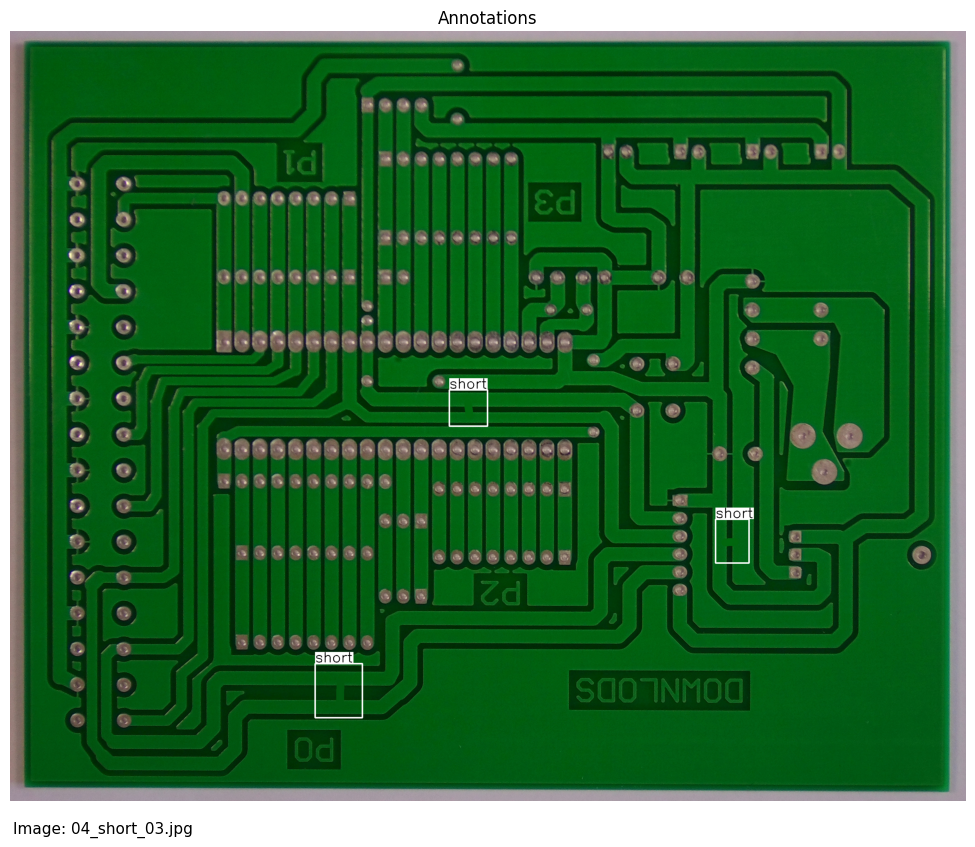

In [14]:
image_name = '04_short_03.jpg'
visualize_annotations(image_name, images_dir, annot_df, is_subfolder=True);

In [15]:
def resize_images(input_dir, output_dir, target_size=(640, 640)):
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Traverse through the subfolders in the input folder
    for root, _, files in os.walk(input_dir):
        for file in files:
            # Check if the file is an image
            if file.lower().endswith(('.jpg')):
                # Read the image
                image_path = os.path.join(root, file)
                image = cv2.imread(image_path)

                # Resize the image
                resized_image = cv2.resize(image, target_size)

                # Save the resized image to the output folder
                output_path = os.path.join(output_dir, file)
                cv2.imwrite(output_path, resized_image)

resized_img_dir = os.path.join(dataset_dir, 'images_resized')
resize_images(images_dir, resized_img_dir)

In [16]:
def resize_annotations(annot_df, target_size=(640, 640)):
    all_data = []

    # Iterate through the annotation DataFrame
    for index, row in annot_df.iterrows():

        # Resize the bounding box coordinates
        width_ratio = target_size[0] / row['width']
        height_ratio = target_size[1] / row['height']

        resized_xmin = int(row['xmin'] * width_ratio)
        resized_ymin = int(row['ymin'] * height_ratio)
        resized_xmax = int(row['xmax'] * width_ratio)
        resized_ymax = int(row['ymax'] * height_ratio)

        # Update the all data list with resized annotations
        all_data.append({
            'filename': row['filename'],
            'width': target_size[0],
            'height': target_size[1],
            'class': row['class'],
            'xmin': resized_xmin,
            'ymin': resized_ymin,
            'xmax': resized_xmax,
            'ymax': resized_ymax
        })

    annot_df_resized = pd.DataFrame(all_data)
    return annot_df_resized

annot_df_resized = resize_annotations(annot_df)
annot_df_resized.head()

filename  width  height         class  xmin  ymin  xmax  ymax
0  06_missing_hole_03.jpg    640     640  missing_hole   340   109   354   123
1  06_missing_hole_03.jpg    640     640  missing_hole   158   212   178   232
2  06_missing_hole_03.jpg    640     640  missing_hole   243   269   257   288
3  06_missing_hole_03.jpg    640     640  missing_hole    54   247    68   265
4  06_missing_hole_03.jpg    640     640  missing_hole   134    56   145    68

In [17]:
# Create the output directory
output_dir = os.path.join(dataset_dir, 'output')
os.makedirs(output_dir, exist_ok=True)

In [18]:
# Convert annotation DataFrame into YOLO labels
# YOLO format: <class_index> <x_center> <y_center> <width> <height>
def convert_to_yolo_labels(annotation_df, classes, target_size=(640, 640)):
    yolo_labels = []

    for _, annot in annotation_df.iterrows():
        filename = annot['filename']
        width, height = annot['width'], annot['height']
        class_name = annot['class']
        xmin, ymin, xmax, ymax = annot['xmin'], annot['ymin'], annot['xmax'], annot['ymax']

        # Convert bounding box coordinates to YOLO format
        x_center = (xmin + xmax) / (2 * width)
        y_center = (ymin + ymax) / (2 * height)
        bbox_width = (xmax - xmin) / width
        bbox_height = (ymax - ymin) / height

        class_index = classes.index(class_name)

        # Append to YOLO labels list
        yolo_labels.append((filename, class_index, x_center, y_center, bbox_width, bbox_height))

    return yolo_labels


classes = ['missing_hole', 'mouse_bite', 'open_circuit',
           'short', 'spur', 'spurious_copper']
yolo_labels = convert_to_yolo_labels(annot_df_resized, classes)

In [19]:
def split_images_and_labels(images_dir, labels, output_dir, train_split=0.95, val_split=0.05):
    # os.makedirs(output_dir, exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'images/train'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'images/val'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'images/test'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels/train'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels/val'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels/test'), exist_ok=True)

    # Group labels by image filename
    image_labels = {}
    for label in labels:
        filename, class_index, x_center, y_center, bbox_width, bbox_height = label
        if filename not in image_labels:
            image_labels[filename] = []
        image_labels[filename].append(label)

    # Shuffle the image filenames
    image_filenames = list(image_labels.keys())
    random.shuffle(image_filenames)

    # Split the dataset
    num_images = len(image_filenames)
    num_train = int(num_images * train_split)
    num_val = int(num_images * val_split)

    train_filenames = image_filenames[:num_train]
    val_filenames = image_filenames[num_train:num_train + num_val]
    test_filenames = image_filenames[num_train + num_val:]

    # Write train, val, test images and labels
    for dataset, filenames in [('train', train_filenames), ('val', val_filenames), ('test', test_filenames)]:
        for filename in filenames:
            labels = image_labels[filename]
            with open(os.path.join(output_dir, f'labels/{dataset}/{os.path.splitext(filename)[0]}.txt'), 'a') as label_file:
                for label in labels:
                    _, class_index, x_center, y_center, bbox_width, bbox_height = label
                    label_file.write(f"{class_index} {x_center} {y_center} {bbox_width} {bbox_height}\n")
            # Copy images to corresponding folders
            shutil.copy(os.path.join(images_dir, filename), os.path.join(output_dir, f'images/{dataset}/{filename}'))

split_images_and_labels(resized_img_dir, yolo_labels, output_dir)

In [20]:
dataset_path = Path(output_dir)
labels = sorted(dataset_path.rglob("*labels/train/*.txt")) # all data in 'labels'

In [21]:
cls_idx = list(range(len(classes)))
print(list(zip(classes, cls_idx)))

[('missing_hole', 0), ('mouse_bite', 1), ('open_circuit', 2), ('short', 3), ('spur', 4), ('spurious_copper', 5)]


In [22]:
indx = [l.stem for l in labels] # uses base filename as ID (no extension)
labels_df = pd.DataFrame([], columns=cls_idx, index=indx)

In [23]:
for label in labels:
    lbl_counter = Counter()

    with open(label,'r') as lf:
        lines = lf.readlines()

    for l in lines:
        # classes for YOLO label uses integer at first position of each line
        lbl_counter[int(l.split(' ')[0])] += 1

    labels_df.loc[label.stem] = lbl_counter

labels_df = labels_df.fillna(0.0) # replace `nan` values with `0.0`
labels_df.head()

<ipython-input-23-635b1554578e>:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  labels_df = labels_df.fillna(0.0) # replace `nan` values with `0.0`


0    1    2    3    4    5
01_missing_hole_01  3.0  0.0  0.0  0.0  0.0  0.0
01_missing_hole_02  3.0  0.0  0.0  0.0  0.0  0.0
01_missing_hole_03  3.0  0.0  0.0  0.0  0.0  0.0
01_missing_hole_04  3.0  0.0  0.0  0.0  0.0  0.0
01_missing_hole_05  4.0  0.0  0.0  0.0  0.0  0.0

In [24]:
ksplit = 3
kf = KFold(n_splits=ksplit, shuffle=True, random_state=20)   # setting random_state for repeatable results

kfolds = list(kf.split(labels_df))

In [25]:
folds = [f'split_{n}' for n in range(1, ksplit + 1)]
folds_df = pd.DataFrame(index=indx, columns=folds)

for idx, (train, val) in enumerate(kfolds, start=1):
    folds_df[f'split_{idx}'].loc[labels_df.iloc[train].index] = 'train'
    folds_df[f'split_{idx}'].loc[labels_df.iloc[val].index] = 'val'

<ipython-input-25-68702af6ce23>:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  folds_df[f'split_{idx}'].loc[labels_df.iloc[train].index] = 'train'
<ipython-input-25-68702af6ce23>:6: FutureWarning: ChainedAssignmentError: behaviour will cha

In [26]:
fold_lbl_distrb = pd.DataFrame(index=folds, columns=cls_idx)

for n, (train_indices, val_indices) in enumerate(kfolds, start=1):
    train_totals = labels_df.iloc[train_indices].sum()
    val_totals = labels_df.iloc[val_indices].sum()

    # To avoid division by zero, we add a small value (1E-7) to the denominator
    ratio = val_totals / (train_totals + 1E-7)
    fold_lbl_distrb.loc[f'split_{n}'] = ratio

fold_lbl_distrb

0         1         2         3         4         5
split_1  0.431193  0.528428  0.325581  0.687273  0.595238  0.404692
split_2  0.481013  0.667883  0.433962  0.463722  0.412651  0.735507
split_3   0.59727  0.340176     0.824  0.380952  0.503205  0.404692

In [27]:
# Initialize a list to store image file paths
images = sorted(dataset_path.rglob("*images/train/*.jpg"))

# Create the necessary directories and dataset YAML files (unchanged)
save_path = Path(dataset_path / f'{ksplit}fold_crossval')
save_path.mkdir(parents=True, exist_ok=True)
ds_yamls = []

for split in folds_df.columns:
    # Create directories
    split_dir = save_path / split
    split_dir.mkdir(parents=True, exist_ok=True)
    (split_dir / 'train' / 'images').mkdir(parents=True, exist_ok=True)
    (split_dir / 'train' / 'labels').mkdir(parents=True, exist_ok=True)
    (split_dir / 'val' / 'images').mkdir(parents=True, exist_ok=True)
    (split_dir / 'val' / 'labels').mkdir(parents=True, exist_ok=True)

    # Create dataset YAML files
    dataset_yaml = split_dir / f'{split}_dataset.yaml'
    ds_yamls.append(dataset_yaml)

    with open(dataset_yaml, 'w') as ds_y:
        yaml.safe_dump({
            'path': split_dir.as_posix(),
            'train': 'train',
            'val': 'val',
            'names': classes
        }, ds_y)

In [28]:
for image, label in zip(images, labels):
    for split, k_split in folds_df.loc[image.stem].items():
        # Destination directory
        img_to_path = save_path / split / k_split / 'images'
        lbl_to_path = save_path / split / k_split / 'labels'

        # Copy image and label files to new directory
        shutil.copy(image, img_to_path / image.name)
        shutil.copy(label, lbl_to_path / label.name)

In [29]:
folds_df.to_csv(save_path / "kfold_datasplit.csv")
fold_lbl_distrb.to_csv(save_path / "kfold_label_distribution.csv")

In [30]:
model = YOLO('yolov8s.pt')

# Additional arguments here
batch = 16
project = 'pcb'
epochs = 100
imgsz=640
save_period=1
verbose=True
# box=6.0 # Weight of the box loss component in the loss function
# cls = 2.0 # Weight of the classification loss in the total loss function
mixup = 0.3 # Blends two images and their labels, creating a composite image

all_data_yaml = f"""
path: {output_dir}
train: images/train
val: images/val

names:
    0: missing_hole
    1: mouse_bite
    2: open_circuit
    3: short
    4: spur
    5: spurious_copper
"""

data_path = os.path.join(root_dir, 'data.yaml')

with open(data_path, 'w') as f:
    f.write(all_data_yaml)

result = model.train(data=data_path,
                     epochs=epochs,
                     batch=batch,
                     lr0=0.001,
                     lrf=0.0001,
                     imgsz=imgsz,
                     save_period=save_period,
                     verbose=verbose,
                     project=project,
                     mixup=mixup)

100%|██████████| 21.5M/21.5M [00:00<00:00, 301MB/s]


Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/images/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=1, cache=False, device=None, workers=8, project=pcb, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=

100%|██████████| 755k/755k [00:00<00:00, 99.0MB/s]


Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 329MB/s]


AMP: checks passed ✅


train: Scanning /content/images/PCB_DATASET/output/labels/train... 658 images, 0 backgrounds, 0 corrupt: 100%|██████████| 658/658 [00:00<00:00, 2325.41it/s]


train: New cache created: /content/images/PCB_DATASET/output/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/images/PCB_DATASET/output/labels/val... 34 images, 0 backgrounds, 0 corrupt: 100%|██████████| 34/34 [00:00<00:00, 1563.77it/s]

val: New cache created: /content/images/PCB_DATASET/output/labels/val.cache


Plotting labels to pcb/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to pcb/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      3.83G      4.038      17.42      2.006         10        640: 100%|██████████| 42/42 [00:19<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]

                   all         34        155   0.000519     0.0932   0.000442   0.000199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      4.64G      2.978      3.857      1.281         19        640: 100%|██████████| 42/42 [00:16<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]

                   all         34        155      0.135      0.308     0.0906     0.0351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.67G      2.629      2.908      1.181         16        640: 100%|██████████| 42/42 [00:15<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.96it/s]

                   all         34        155      0.582      0.414      0.448      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      4.71G      2.466      2.419       1.14          7        640: 100%|██████████| 42/42 [00:15<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.50it/s]

                   all         34        155      0.661      0.461      0.514      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.74G      2.361      2.174      1.132         17        640: 100%|██████████| 42/42 [00:15<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.30it/s]

                   all         34        155      0.738      0.588      0.664      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      4.79G      2.346      2.051      1.099          6        640: 100%|██████████| 42/42 [00:15<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.66it/s]

                   all         34        155      0.868      0.658      0.774      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      4.81G      2.252      1.822      1.078         15        640: 100%|██████████| 42/42 [00:15<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]

                   all         34        155       0.86      0.705      0.805      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      4.86G      2.238      1.805      1.069         31        640: 100%|██████████| 42/42 [00:16<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]

                   all         34        155      0.919      0.679      0.809      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      4.88G      2.231      1.805      1.061          9        640: 100%|██████████| 42/42 [00:15<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.36it/s]

                   all         34        155      0.832      0.708      0.822      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.93G      2.199      1.719      1.057         17        640: 100%|██████████| 42/42 [00:15<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.59it/s]

                   all         34        155      0.794      0.706      0.798       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      4.96G      2.111      1.629      1.042         14        640: 100%|██████████| 42/42 [00:16<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]


                   all         34        155      0.771      0.737      0.804      0.306

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100         5G      2.101      1.605      1.039         21        640: 100%|██████████| 42/42 [00:15<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.29it/s]

                   all         34        155      0.885      0.808      0.886      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      5.03G       2.12      1.626      1.039         22        640: 100%|██████████| 42/42 [00:15<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.88it/s]


                   all         34        155      0.926      0.783      0.887      0.401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      5.08G      2.061       1.51      1.025         32        640: 100%|██████████| 42/42 [00:15<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]

                   all         34        155       0.88      0.774      0.874      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100       5.1G      2.135      1.572      1.048         31        640: 100%|██████████| 42/42 [00:15<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.06it/s]

                   all         34        155      0.906      0.825      0.925      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      5.15G      2.084      1.599      1.036         26        640: 100%|██████████| 42/42 [00:16<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.28it/s]

                   all         34        155      0.882      0.873      0.931      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      5.18G      2.035      1.481       1.02          9        640: 100%|██████████| 42/42 [00:15<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.56it/s]

                   all         34        155      0.902      0.872      0.919      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      5.22G      2.003      1.466      1.018         13        640: 100%|██████████| 42/42 [00:15<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.29it/s]

                   all         34        155      0.915      0.819      0.882      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      5.25G      1.984      1.428       1.01          7        640: 100%|██████████| 42/42 [00:15<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.95it/s]

                   all         34        155      0.941      0.831       0.92      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      5.29G      1.981      1.393      1.006          8        640: 100%|██████████| 42/42 [00:15<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.35it/s]


                   all         34        155      0.979      0.831      0.931      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      5.32G      2.024      1.448      1.003          9        640: 100%|██████████| 42/42 [00:16<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.57it/s]

                   all         34        155      0.875      0.868      0.927      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      5.37G      2.024      1.397      1.007         16        640: 100%|██████████| 42/42 [00:16<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.31it/s]

                   all         34        155      0.909      0.859      0.909      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      5.39G      1.959       1.34       1.01         10        640: 100%|██████████| 42/42 [00:15<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.89it/s]

                   all         34        155      0.887      0.875      0.923       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      5.44G      1.974      1.409      1.008         22        640: 100%|██████████| 42/42 [00:15<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]

                   all         34        155       0.93       0.86      0.925      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      5.46G      1.939      1.368     0.9973         12        640: 100%|██████████| 42/42 [00:15<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]

                   all         34        155      0.934      0.865      0.916      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      5.51G       1.97      1.373      1.006          6        640: 100%|██████████| 42/42 [00:15<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.65it/s]

                   all         34        155      0.901       0.86      0.914      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      5.54G      1.964      1.339      1.005         22        640: 100%|██████████| 42/42 [00:15<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.43it/s]

                   all         34        155      0.963      0.859      0.926      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      5.59G      1.941       1.31     0.9835         22        640: 100%|██████████| 42/42 [00:15<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.52it/s]

                   all         34        155      0.955      0.879      0.929      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      5.61G      1.894      1.266     0.9842         10        640: 100%|██████████| 42/42 [00:15<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.98it/s]

                   all         34        155      0.947      0.831      0.929      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      5.66G      1.867       1.28     0.9736          4        640: 100%|██████████| 42/42 [00:15<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]


                   all         34        155       0.95      0.879      0.938      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      5.68G      1.896      1.284     0.9855          4        640: 100%|██████████| 42/42 [00:15<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]

                   all         34        155      0.933      0.919      0.947      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      5.73G      1.888      1.303     0.9799          5        640: 100%|██████████| 42/42 [00:16<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.46it/s]

                   all         34        155      0.952      0.857       0.94      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      5.75G      1.858      1.268     0.9797          4        640: 100%|██████████| 42/42 [00:15<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.14it/s]

                   all         34        155      0.921        0.9      0.954      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100       5.8G      1.864      1.237     0.9787         10        640: 100%|██████████| 42/42 [00:15<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.92it/s]

                   all         34        155      0.916      0.909       0.95      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      6.15G      1.877      1.282     0.9698         13        640: 100%|██████████| 42/42 [00:16<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.36it/s]

                   all         34        155      0.963      0.888      0.949      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100       6.2G      1.872      1.286     0.9727          7        640: 100%|██████████| 42/42 [00:16<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.98it/s]

                   all         34        155      0.933      0.925      0.958      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      6.22G      1.867      1.189     0.9777         10        640: 100%|██████████| 42/42 [00:15<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.90it/s]

                   all         34        155      0.969      0.884      0.964      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      6.27G      1.837      1.164     0.9637         12        640: 100%|██████████| 42/42 [00:15<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.15it/s]

                   all         34        155      0.921      0.907      0.956      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100       6.3G      1.816      1.158     0.9575         10        640: 100%|██████████| 42/42 [00:15<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]

                   all         34        155      0.964      0.935      0.971      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      6.35G      1.831      1.181      0.959         16        640: 100%|██████████| 42/42 [00:15<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]


                   all         34        155       0.94      0.901      0.969      0.468

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      6.37G       1.84      1.209     0.9763          8        640: 100%|██████████| 42/42 [00:15<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.97it/s]

                   all         34        155      0.959      0.942      0.972      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      6.42G      1.813      1.173     0.9626         14        640: 100%|██████████| 42/42 [00:15<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.26it/s]

                   all         34        155      0.949       0.94      0.968      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      6.44G      1.855      1.227     0.9677         23        640: 100%|██████████| 42/42 [00:16<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.36it/s]

                   all         34        155       0.96      0.927      0.958       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      6.49G      1.811      1.178     0.9632         26        640: 100%|██████████| 42/42 [00:15<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.05it/s]

                   all         34        155      0.966      0.929      0.974      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      6.52G      1.755      1.125     0.9481         14        640: 100%|██████████| 42/42 [00:16<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         34        155      0.937      0.908      0.963      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      6.56G      1.794      1.135     0.9557         14        640: 100%|██████████| 42/42 [00:15<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.05it/s]

                   all         34        155      0.942      0.923      0.964      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      6.59G      1.782      1.124     0.9629         18        640: 100%|██████████| 42/42 [00:15<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.08it/s]

                   all         34        155      0.948      0.934      0.964      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      6.64G      1.796      1.142     0.9654         14        640: 100%|██████████| 42/42 [00:15<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.13it/s]

                   all         34        155      0.945      0.911      0.967      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      6.66G      1.807      1.175     0.9667          6        640: 100%|██████████| 42/42 [00:16<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.87it/s]


                   all         34        155      0.971      0.913      0.974      0.497

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      6.77G      1.773      1.103     0.9528         16        640: 100%|██████████| 42/42 [00:16<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]

                   all         34        155      0.982      0.896      0.966      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      6.79G      1.751      1.115     0.9446         19        640: 100%|██████████| 42/42 [00:16<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.62it/s]

                   all         34        155      0.961      0.906      0.969      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      6.89G      1.768      1.117     0.9499          9        640: 100%|██████████| 42/42 [00:15<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.03it/s]

                   all         34        155      0.939      0.947      0.971      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      6.97G      1.751      1.085     0.9492         14        640: 100%|██████████| 42/42 [00:15<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.99it/s]

                   all         34        155      0.979      0.907      0.985      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      7.02G      1.744      1.116     0.9496         22        640: 100%|██████████| 42/42 [00:15<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]

                   all         34        155      0.964      0.937      0.985        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      7.09G      1.754      1.126     0.9508         23        640: 100%|██████████| 42/42 [00:16<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.88it/s]

                   all         34        155      0.975      0.935      0.983      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100       7.2G      1.736      1.071     0.9415         18        640: 100%|██████████| 42/42 [00:15<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.34it/s]

                   all         34        155      0.982      0.901      0.974      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      7.22G      1.737      1.063     0.9433         36        640: 100%|██████████| 42/42 [00:15<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.11it/s]

                   all         34        155      0.944      0.962      0.979      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      7.27G      1.696      1.048     0.9375          6        640: 100%|██████████| 42/42 [00:15<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.28it/s]

                   all         34        155      0.961      0.954      0.984      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      7.39G      1.737      1.085     0.9379         19        640: 100%|██████████| 42/42 [00:15<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.42it/s]

                   all         34        155      0.987      0.934      0.983       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      7.44G      1.715      1.045     0.9402         15        640: 100%|██████████| 42/42 [00:15<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

                   all         34        155      0.978      0.946      0.992      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      7.46G      1.695      1.062     0.9331          6        640: 100%|██████████| 42/42 [00:15<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]

                   all         34        155       0.96      0.959      0.986      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      7.61G      1.656      1.007      0.931         14        640: 100%|██████████| 42/42 [00:15<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.96it/s]


                   all         34        155      0.945      0.943       0.98      0.477

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      7.63G      1.695      1.026     0.9321         15        640: 100%|██████████| 42/42 [00:15<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.43it/s]

                   all         34        155      0.949      0.952      0.985      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      7.75G      1.717      1.031     0.9304         15        640: 100%|██████████| 42/42 [00:15<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.90it/s]

                   all         34        155      0.959      0.945       0.99      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      7.78G      1.684      1.026     0.9401          9        640: 100%|██████████| 42/42 [00:15<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


                   all         34        155      0.992      0.945      0.992      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      7.82G      1.689      1.043     0.9414         19        640: 100%|██████████| 42/42 [00:15<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.33it/s]

                   all         34        155      0.992      0.919      0.994      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      7.91G       1.72      1.056     0.9411         21        640: 100%|██████████| 42/42 [00:15<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]

                   all         34        155      0.972      0.952      0.987      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      7.95G      1.669     0.9976     0.9275         23        640: 100%|██████████| 42/42 [00:15<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]

                   all         34        155      0.982      0.915      0.983      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      7.98G      1.693      1.057     0.9433         12        640: 100%|██████████| 42/42 [00:16<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.07it/s]


                   all         34        155      0.972       0.95      0.985      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      8.13G       1.65      1.018     0.9277         11        640: 100%|██████████| 42/42 [00:15<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.42it/s]

                   all         34        155      0.964      0.954      0.983      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      8.15G      1.661     0.9938     0.9212         17        640: 100%|██████████| 42/42 [00:15<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.30it/s]

                   all         34        155      0.963      0.975      0.988      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100       8.2G      1.632     0.9712     0.9241         11        640: 100%|██████████| 42/42 [00:15<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.33it/s]

                   all         34        155       0.98      0.962      0.993      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      8.23G      1.653     0.9981     0.9317         15        640: 100%|██████████| 42/42 [00:15<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]

                   all         34        155      0.976      0.957      0.988      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      8.37G      1.667      1.007     0.9208          8        640: 100%|██████████| 42/42 [00:16<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         34        155      0.964      0.977      0.991      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      8.45G      1.612      0.964     0.9265          4        640: 100%|██████████| 42/42 [00:15<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.16it/s]

                   all         34        155      0.971      0.924       0.99      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100       8.5G      1.589      0.928     0.9257         14        640: 100%|██████████| 42/42 [00:15<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]

                   all         34        155       0.97       0.96      0.992       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      8.53G      1.631     0.9874     0.9243         21        640: 100%|██████████| 42/42 [00:15<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.12it/s]

                   all         34        155       0.97      0.931      0.988      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      8.64G      1.569     0.9248     0.9155         12        640: 100%|██████████| 42/42 [00:15<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.07it/s]

                   all         34        155      0.961      0.967      0.993      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      8.72G      1.631     0.9626     0.9244         28        640: 100%|██████████| 42/42 [00:15<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]

                   all         34        155      0.977      0.961      0.991      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      8.77G      1.624     0.9655     0.9269         13        640: 100%|██████████| 42/42 [00:15<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.65it/s]

                   all         34        155      0.978      0.974      0.991      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      9.12G      1.644     0.9732     0.9222         23        640: 100%|██████████| 42/42 [00:15<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.98it/s]

                   all         34        155      0.975      0.964      0.984        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      9.17G      1.626     0.9716      0.912         22        640: 100%|██████████| 42/42 [00:15<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.81it/s]

                   all         34        155       0.94      0.963      0.985      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      9.19G      1.628     0.9812     0.9298          5        640: 100%|██████████| 42/42 [00:15<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]

                   all         34        155      0.969      0.969      0.986      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      9.25G      1.583     0.9485     0.9107         18        640: 100%|██████████| 42/42 [00:15<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.91it/s]

                   all         34        155      0.977      0.975      0.992      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      9.27G      1.562      0.906     0.9091         14        640: 100%|██████████| 42/42 [00:15<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.14it/s]

                   all         34        155      0.975      0.968      0.988      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      9.32G      1.612     0.9583     0.9177         19        640: 100%|██████████| 42/42 [00:15<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]

                   all         34        155      0.975      0.972      0.992      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      9.34G      1.551      0.906     0.9167         13        640: 100%|██████████| 42/42 [00:16<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.90it/s]

                   all         34        155      0.974      0.967      0.992      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      9.39G      1.592     0.9386     0.9057         20        640: 100%|██████████| 42/42 [00:15<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.07it/s]

                   all         34        155      0.981      0.975      0.992      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      9.41G      1.567     0.9313     0.9111          9        640: 100%|██████████| 42/42 [00:15<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.95it/s]


                   all         34        155      0.979      0.976      0.993      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      9.46G      1.573     0.9412     0.9174          6        640: 100%|██████████| 42/42 [00:16<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.38it/s]

                   all         34        155       0.98      0.977      0.994       0.52


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      9.48G      1.354     0.6573      0.891         10        640: 100%|██████████| 42/42 [00:15<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.20it/s]

                   all         34        155      0.975      0.973      0.992      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      9.53G      1.356     0.6452      0.892         10        640: 100%|██████████| 42/42 [00:13<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.68it/s]

                   all         34        155      0.979      0.946      0.992       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      9.55G      1.322     0.6283     0.8928          9        640: 100%|██████████| 42/42 [00:13<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.05it/s]

                   all         34        155      0.965      0.965      0.993      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      9.61G      1.349     0.6366     0.8878          7        640: 100%|██████████| 42/42 [00:13<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.86it/s]

                   all         34        155      0.952       0.98      0.993      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      9.66G      1.331     0.6268     0.8885          8        640: 100%|██████████| 42/42 [00:13<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.62it/s]

                   all         34        155      0.947      0.977      0.993      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      9.74G      1.288      0.595     0.8827          7        640: 100%|██████████| 42/42 [00:13<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.14it/s]

                   all         34        155      0.972      0.948      0.992      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100       9.8G      1.294     0.6103      0.881          7        640: 100%|██████████| 42/42 [00:13<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.59it/s]

                   all         34        155      0.957      0.973      0.993       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      9.88G       1.27     0.5951     0.8802          9        640: 100%|██████████| 42/42 [00:13<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]

                   all         34        155       0.95      0.981      0.993      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      9.94G        1.3     0.6048     0.8781         10        640: 100%|██████████| 42/42 [00:13<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.00it/s]

                   all         34        155      0.949      0.981      0.993      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100        10G      1.264     0.5919     0.8852          9        640: 100%|██████████| 42/42 [00:13<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.99it/s]

                   all         34        155      0.952      0.985      0.993      0.518



100 epochs completed in 0.478 hours.
Optimizer stripped from pcb/train/weights/last.pt, 22.5MB
Optimizer stripped from pcb/train/weights/best.pt, 22.5MB

Validating pcb/train/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.34it/s]


                   all         34        155       0.97       0.96      0.992      0.531
          missing_hole          6         29          1      0.967      0.995      0.583
            mouse_bite          7         35       0.93      0.971      0.985      0.494
          open_circuit          6         26          1       0.86       0.99       0.45
                 short          6         27       0.95      0.963      0.991      0.561
                  spur          3         14      0.962          1      0.995      0.588
       spurious_copper          6         24       0.98          1      0.995      0.509
Speed: 0.2ms preprocess, 5.3ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to pcb/train


In [31]:
results_dir = '/content/pcb/train'
dest_results_dir = os.path.join(root_dir, 'results')

shutil.copytree(results_dir, dest_results_dir)

'/content/images/results'

In [32]:
results_df = pd.read_csv(os.path.join(dest_results_dir, 'results.csv'))
results_df.columns = results_df.columns.str.strip()
results_df = results_df.apply(pd.to_numeric, errors='coerce').dropna()
results_df.head()

epoch     time  train/box_loss  train/cls_loss  train/dfl_loss  \
0      1  24.9889         4.03802        17.42150         2.00560   
1      2  43.2028         2.97845         3.85666         1.28052   
2      3  60.3305         2.62913         2.90809         1.18065   
3      4  77.7009         2.46628         2.41862         1.13996   
4      5  94.2674         2.36109         2.17371         1.13245   

   metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0               0.00052            0.09315           0.00044   
1               0.13537            0.30782           0.09059   
2               0.58223            0.41379           0.44789   
3               0.66138            0.46135           0.51357   
4               0.73800            0.58801           0.66450   

   metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
0              0.00020       2.93923      31.14240       1.30329  0.000325   
1              0.03510       2.82568      13.72690       1.25032  0.000652   
2              0.19898       2.16549       1.99395       1.09652  0.000972   
3              0.17889       2.37646       1.72174       1.13298  0.000970   
4              0.28544       1.91364       1.48452       1.03323  0.000960   

     lr/pg1    lr/pg2  
0  0.000325  0.000325  
1  0.000652  0.000652  
2  0.000972  0.000972  
3  0.000970  0.000970  
4  0.000960  0.000960

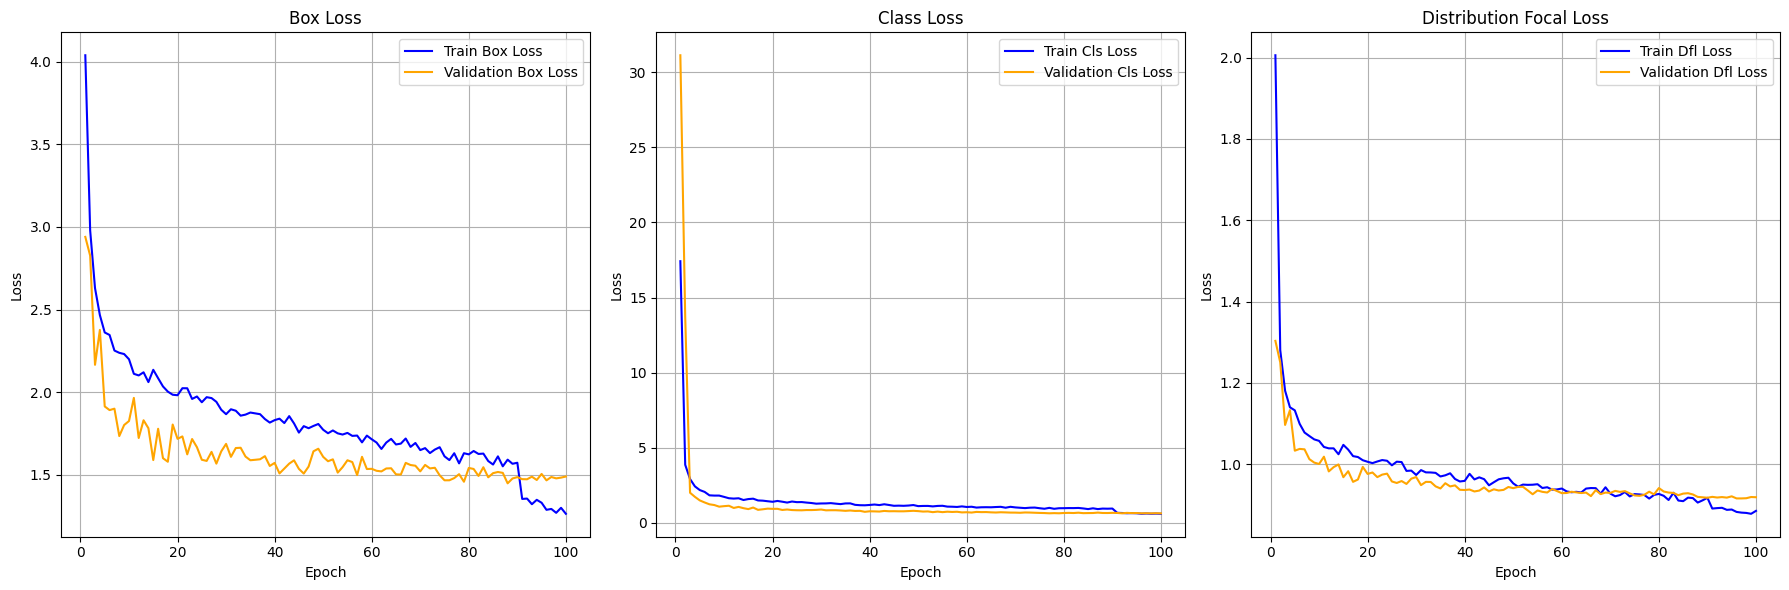

In [33]:
epochs = results_df['epoch']
train_box_loss = results_df['train/box_loss']
val_box_loss = results_df['val/box_loss']
train_cls_loss = results_df['train/cls_loss']
val_cls_loss = results_df['val/cls_loss']
train_dfl_loss = results_df['train/dfl_loss']
val_dfl_loss = results_df['val/dfl_loss']

# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot box loss
axs[0].plot(epochs, train_box_loss, label='Train Box Loss', color='blue')
axs[0].plot(epochs, val_box_loss, label='Validation Box Loss', color='orange')
axs[0].set_title('Box Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

# Plot cls loss
axs[1].plot(epochs, train_cls_loss, label='Train Cls Loss', color='blue')
axs[1].plot(epochs, val_cls_loss, label='Validation Cls Loss', color='orange')
axs[1].set_title('Class Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)

# Plot dfl loss
axs[2].plot(epochs, train_dfl_loss, label='Train Dfl Loss', color='blue')
axs[2].plot(epochs, val_dfl_loss, label='Validation Dfl Loss', color='orange')
axs[2].set_title('Distribution Focal Loss')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Loss')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

In [34]:
best_model_path = os.path.join(dest_results_dir, 'weights/best.pt')
model = YOLO(best_model_path)

test_data_dir = os.path.join(output_dir, 'images/val')
metrics = model(source=test_data_dir, imgsz=640, conf=0.25, save=True, save_txt=True, save_conf=True)


image 1/34 /content/images/PCB_DATASET/output/images/val/01_short_20.jpg: 640x640 4 shorts, 21.1ms
image 2/34 /content/images/PCB_DATASET/output/images/val/01_spurious_copper_18.jpg: 640x640 3 spurious_coppers, 17.0ms
image 3/34 /content/images/PCB_DATASET/output/images/val/04_missing_hole_12.jpg: 640x640 3 missing_holes, 16.8ms
image 4/34 /content/images/PCB_DATASET/output/images/val/04_open_circuit_02.jpg: 640x640 3 open_circuits, 16.1ms
image 5/34 /content/images/PCB_DATASET/output/images/val/04_open_circuit_04.jpg: 640x640 3 open_circuits, 16.0ms
image 6/34 /content/images/PCB_DATASET/output/images/val/04_short_01.jpg: 640x640 3 shorts, 16.0ms
image 7/34 /content/images/PCB_DATASET/output/images/val/04_spurious_copper_14.jpg: 640x640 3 spurious_coppers, 15.3ms
image 8/34 /content/images/PCB_DATASET/output/images/val/04_spurious_copper_19.jpg: 640x640 3 spurious_coppers, 15.3ms
image 9/34 /content/images/PCB_DATASET/output/images/val/05_mouse_bite_10.jpg: 640x640 5 mouse_bites, 15.

In [35]:
predict_dir = '/content/runs/detect/predict'
dest_predict_dir = os.path.join(root_dir, 'results/predict')

shutil.copytree(predict_dir, dest_predict_dir)

'/content/images/results/predict'

In [36]:
def yolo_to_original_annot(image_name, yolo_labels, annot_df, classes):
    original_annot = []

    for yolo_label in yolo_labels:
        # Extract original width and height from annotation DataFrame
        original_size = annot_df.loc[annot_df['filename'] == image_name, ['width', 'height']].iloc[0]
        original_width, original_height = original_size['width'], original_size['height']

        # Extract YOLO label components
        class_index, x_center, y_center, bbox_width, bbox_height, confidence = yolo_label

        # Scale bounding box coordinates and dimensions to original size
        original_x_center = x_center * original_width
        original_y_center = y_center * original_height
        original_bbox_width = bbox_width * original_width
        original_bbox_height = bbox_height * original_height

        # Calculate original bounding box coordinates
        original_x_min = original_x_center - original_bbox_width / 2
        original_y_min = original_y_center - original_bbox_height / 2
        original_x_max = original_x_center + original_bbox_width / 2
        original_y_max = original_y_center + original_bbox_height / 2

        # Append original annotation to list
        original_annot.append({
            'filename': image_name,
            'width': int(original_width),
            'height': int(original_height),
            'class': classes[int(class_index)],
            'xmin': int(original_x_min),
            'ymin': int(original_y_min),
            'xmax': int(original_x_max),
            'ymax': int(original_y_max),
            'confidence': confidence
        })

    return pd.DataFrame(original_annot)

In [39]:
def read_yolo_labels_from_file(file_path):
    labels = []
    with open(file_path, 'r') as file:
        for line in file:
            values = line.strip().split()
            values = [float(value) for value in values]
            labels.append(values)
    return labels

file_path = os.path.join(dest_predict_dir, 'labels/08_missing_hole_10.txt')
yolo_labels = read_yolo_labels_from_file(file_path)
yolo_labels

[[0.0, 0.690731, 0.494994, 0.0236565, 0.0303247, 0.78785],
 [0.0, 0.096005, 0.306152, 0.0239209, 0.0290007, 0.787189],
 [0.0, 0.310339, 0.686001, 0.02597, 0.032739, 0.755402],
 [0.0, 0.8388, 0.774072, 0.0145414, 0.0189566, 0.313933]]

In [40]:
pred_annot_df = yolo_to_original_annot('08_missing_hole_10.jpg', yolo_labels, annot_df, classes)
pred_annot_df.head()

filename  width  height         class  xmin  ymin  xmax  \
0  08_missing_hole_10.jpg   2759    2154  missing_hole  1873  1033  1938   
1  08_missing_hole_10.jpg   2759    2154  missing_hole   231   628   297   
2  08_missing_hole_10.jpg   2759    2154  missing_hole   820  1442   892   
3  08_missing_hole_10.jpg   2759    2154  missing_hole  2294  1646  2334   

   ymax  confidence  
0  1098    0.787850  
1   690    0.787189  
2  1512    0.755402  
3  1687    0.313933

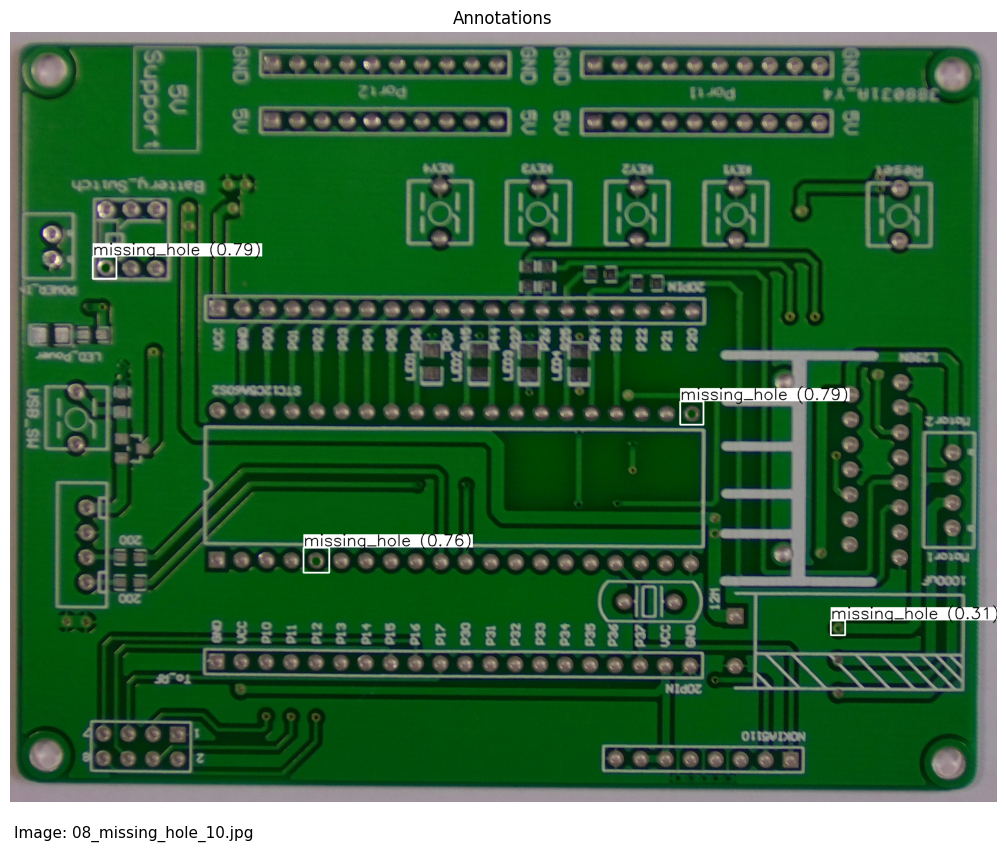

In [41]:
visualize_annotations('08_missing_hole_10.jpg', images_dir, pred_annot_df, is_subfolder=True);

In [42]:
model.export()

Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)

PyTorch: starting from '/content/images/results/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 10, 8400) (21.5 MB)

TorchScript: starting export with torch 2.6.0+cu124...
TorchScript: export success ✅ 4.3s, saved as '/content/images/results/weights/best.torchscript' (42.9 MB)

Export complete (6.8s)
Results saved to /content/images/results/weights
Predict:         yolo predict task=detect model=/content/images/results/weights/best.torchscript imgsz=640  
Validate:        yolo val task=detect model=/content/images/results/weights/best.torchscript imgsz=640 data=/content/images/data.yaml  
Visualize:       https://netron.app


'/content/images/results/weights/best.torchscript'

# GRAD-CAM

In [45]:
pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 102.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39680 sha256=ac0c278bf50d7da647e800e8ad4919a3720926633794db1ceaf881dceb89a5d4
  Stored in directory: /root/.cache/pip/wheels/8b/0d/d2/b12bec1ccc028921fb98158042ade2d19dae73925dfc636954
Successfully built grad-cam


In [89]:
import torch
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms import Compose, ToTensor, Resize

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# -------------------------------
# ✅ Load TorchScript model properly
# -------------------------------
ts_model = torch.jit.load("/content/images/results/weights/best.torchscript").eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ts_model = ts_model.to(device)

# -------------------------------
# 🧠 Custom wrapper (if needed for CAM)
# -------------------------------
class WrapperModel(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        return self.model(x)

wrapped_model = WrapperModel(ts_model)

# -------------------------------
# 📷 Load and transform image
# -------------------------------
img_path = "/content/images/results/predict/10_missing_hole_04.jpg"
img = Image.open(img_path).convert("RGB")
img_resized = img.resize((640, 640))
rgb_img = np.array(img_resized).astype(np.float32) / 255.0
transform = Compose([Resize((640, 640)), ToTensor()])
input_tensor = transform(img).unsqueeze(0).to(device)

# -------------------------------
# 🔍 Run inference to get boxes/classes
# -------------------------------
from ultralytics import YOLO
yolo_model = YOLO("/content/images/results/weights/best.pt")
results = yolo_model(img_path)[0]
labels = results.boxes.cls.cpu().numpy().astype(int)

# -------------------------------
# 🔬 Pick a layer from the model manually
# -------------------------------
# TorchScript model doesn't allow easy layer enumeration, so pick known conv layer name
target_layers = [model.model[19]]
  # <- adjust based on your architecture
# If this throws, we might need to inspect ts_model.graph

# -------------------------------
# 🔥 Apply Grad-CAM
# -------------------------------
cam = GradCAM(model=wrapped_model, target_layers=target_layers)
targets = [ClassifierOutputTarget(int(labels[0]))] if len(labels) > 0 else None
grayscale_cam = cam(input_tensor=input_tensor.clone(), targets=targets)[0]

# -------------------------------
# 🌡️ Overlay heatmap
# -------------------------------
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
plt.imshow(visualization)
plt.title(f"Grad-CAM: Class {labels[0] if len(labels) > 0 else 'N/A'}")
plt.axis("off")
plt.show()



image 1/1 /content/images/results/predict/10_missing_hole_04.jpg: 640x640 5 missing_holes, 16.3ms
Speed: 2.6ms preprocess, 16.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


RuntimeError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript, serialized code (most recent call last):
  File "code/__torch__/ultralytics/nn/tasks/___torch_mangle_1218.py", line 74, in forward
    _35 = (_18).forward(act, _34, )
    _36 = (_20).forward((_19).forward(act, _35, ), _29, )
    _37 = (_22).forward(_33, _35, (_21).forward(act, _36, ), )
           ~~~~~~~~~~~~ <--- HERE
    return _37
  File "code/__torch__/ultralytics/nn/modules/head/___torch_mangle_1216.py", line 45, in forward
    anchor_points = torch.unsqueeze(CONSTANTS.c0, 0)
    lt, rb, = torch.chunk(_13, 2, 1)
    x1y1 = torch.sub(anchor_points, lt)
           ~~~~~~~~~ <--- HERE
    x2y2 = torch.add(anchor_points, rb)
    c_xy = torch.div(torch.add(x1y1, x2y2), CONSTANTS.c1)

Traceback of TorchScript, original code (most recent call last):
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/tal.py(382): dist2bbox
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/head.py(159): decode_bboxes
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/head.py(140): _inference
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/head.py(75): forward
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py(1729): _slow_forward
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py(1750): _call_impl
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py(1739): _wrapped_call_impl
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/tasks.py(159): _predict_once
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/tasks.py(138): predict
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/tasks.py(120): forward
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py(1729): _slow_forward
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py(1750): _call_impl
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py(1739): _wrapped_call_impl
/usr/local/lib/python3.11/dist-packages/torch/jit/_trace.py(1276): trace_module
/usr/local/lib/python3.11/dist-packages/torch/jit/_trace.py(696): _trace_impl
/usr/local/lib/python3.11/dist-packages/torch/jit/_trace.py(1000): trace
/usr/local/lib/python3.11/dist-packages/ultralytics/engine/exporter.py(532): export_torchscript
/usr/local/lib/python3.11/dist-packages/ultralytics/engine/exporter.py(191): outer_func
/usr/local/lib/python3.11/dist-packages/ultralytics/engine/exporter.py(445): __call__
/usr/local/lib/python3.11/dist-packages/ultralytics/engine/model.py(728): export
<ipython-input-42-1c3cac462029>(1): <cell line: 0>
/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py(3553): run_code
/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py(3473): run_ast_nodes
/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py(3257): run_cell_async
/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py(78): _pseudo_sync_runner
/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py(3030): _run_cell
/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py(2975): run_cell
/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py(528): run_cell
/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py(383): do_execute
/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py(730): execute_request
/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py(406): dispatch_shell
/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py(499): process_one
/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py(510): dispatch_queue
/usr/lib/python3.11/asyncio/events.py(84): _run
/usr/lib/python3.11/asyncio/base_events.py(1936): _run_once
/usr/lib/python3.11/asyncio/base_events.py(608): run_forever
/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py(205): start
/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py(712): start
/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py(992): launch_instance
/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py(37): <module>
<frozen runpy>(88): _run_code
<frozen runpy>(198): _run_module_as_main
RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!


In [90]:
import torch
import cv2
import numpy as np

# Load TorchScript model and move to correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ts_model = torch.jit.load("/content/images/results/weights/best.torchscript").to(device)
ts_model.eval()

# Load image
img_path = "/content/images/results/predict/10_missing_hole_04.jpg"
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (640, 640))
image = image / 255.0  # normalize
image = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).float().to(device)

# Run inference
with torch.no_grad():
    output = ts_model(image)

print("Inference successful!")


RuntimeError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript, serialized code (most recent call last):
  File "code/__torch__/ultralytics/nn/tasks/___torch_mangle_1218.py", line 74, in forward
    _35 = (_18).forward(act, _34, )
    _36 = (_20).forward((_19).forward(act, _35, ), _29, )
    _37 = (_22).forward(_33, _35, (_21).forward(act, _36, ), )
           ~~~~~~~~~~~~ <--- HERE
    return _37
  File "code/__torch__/ultralytics/nn/modules/head/___torch_mangle_1216.py", line 45, in forward
    anchor_points = torch.unsqueeze(CONSTANTS.c0, 0)
    lt, rb, = torch.chunk(_13, 2, 1)
    x1y1 = torch.sub(anchor_points, lt)
           ~~~~~~~~~ <--- HERE
    x2y2 = torch.add(anchor_points, rb)
    c_xy = torch.div(torch.add(x1y1, x2y2), CONSTANTS.c1)

Traceback of TorchScript, original code (most recent call last):
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/tal.py(382): dist2bbox
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/head.py(159): decode_bboxes
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/head.py(140): _inference
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/modules/head.py(75): forward
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py(1729): _slow_forward
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py(1750): _call_impl
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py(1739): _wrapped_call_impl
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/tasks.py(159): _predict_once
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/tasks.py(138): predict
/usr/local/lib/python3.11/dist-packages/ultralytics/nn/tasks.py(120): forward
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py(1729): _slow_forward
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py(1750): _call_impl
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py(1739): _wrapped_call_impl
/usr/local/lib/python3.11/dist-packages/torch/jit/_trace.py(1276): trace_module
/usr/local/lib/python3.11/dist-packages/torch/jit/_trace.py(696): _trace_impl
/usr/local/lib/python3.11/dist-packages/torch/jit/_trace.py(1000): trace
/usr/local/lib/python3.11/dist-packages/ultralytics/engine/exporter.py(532): export_torchscript
/usr/local/lib/python3.11/dist-packages/ultralytics/engine/exporter.py(191): outer_func
/usr/local/lib/python3.11/dist-packages/ultralytics/engine/exporter.py(445): __call__
/usr/local/lib/python3.11/dist-packages/ultralytics/engine/model.py(728): export
<ipython-input-42-1c3cac462029>(1): <cell line: 0>
/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py(3553): run_code
/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py(3473): run_ast_nodes
/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py(3257): run_cell_async
/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py(78): _pseudo_sync_runner
/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py(3030): _run_cell
/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py(2975): run_cell
/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py(528): run_cell
/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py(383): do_execute
/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py(730): execute_request
/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py(406): dispatch_shell
/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py(499): process_one
/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py(510): dispatch_queue
/usr/lib/python3.11/asyncio/events.py(84): _run
/usr/lib/python3.11/asyncio/base_events.py(1936): _run_once
/usr/lib/python3.11/asyncio/base_events.py(608): run_forever
/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py(205): start
/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py(712): start
/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py(992): launch_instance
/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py(37): <module>
<frozen runpy>(88): _run_code
<frozen runpy>(198): _run_module_as_main
RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!


In [92]:
from ultralytics import YOLO
import torch

# Assuming this is your trained model object
model = YOLO('/content/images/results/weights/best.pt')  # Adjust path if needed

# Force export to TorchScript with proper CUDA device alignment
model.export(format='torchscript', device=0 if torch.cuda.is_available() else 'cpu')


Ultralytics 8.3.102 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs

PyTorch: starting from '/content/images/results/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 10, 8400) (21.5 MB)

TorchScript: starting export with torch 2.6.0+cu124...
TorchScript: export success ✅ 1.3s, saved as '/content/images/results/weights/best.torchscript' (42.9 MB)

Export complete (1.6s)
Results saved to /content/images/results/weights
Predict:         yolo predict task=detect model=/content/images/results/weights/best.torchscript imgsz=640  
Validate:        yolo val task=detect model=/content/images/results/weights/best.torchscript imgsz=640 data=/content/images/data.yaml  
Visualize:       https://netron.app


'/content/images/results/weights/best.torchscript'

In [93]:
import torch
import cv2

# Load TorchScript model
ts_model = torch.jit.load("/content/images/results/weights/best.torchscript").to("cuda").eval()

# Load image and preprocess
img = cv2.imread("/content/images/results/predict/10_missing_hole_04.jpg")
img_resized = cv2.resize(img, (640, 640))
img_tensor = torch.from_numpy(img_resized).permute(2, 0, 1).float().div(255.0).unsqueeze(0).to("cuda")

# Inference
with torch.no_grad():
    preds = ts_model(img_tensor)

print(preds)


tensor([[[7.4995e+00, 1.4951e+01, 2.1449e+01,  ..., 5.5682e+02, 5.8290e+02, 6.2264e+02],
         [4.4452e+00, 3.7066e+00, 3.7043e+00,  ..., 6.3179e+02, 6.2544e+02, 6.1900e+02],
         [1.4848e+01, 2.8109e+01, 3.9985e+01,  ..., 2.4766e+02, 1.6132e+02, 3.6364e+01],
         ...,
         [4.9137e-05, 5.2314e-05, 2.9259e-05,  ..., 4.1499e-06, 4.2626e-06, 3.4283e-06],
         [5.1184e-05, 2.5581e-05, 2.6655e-05,  ..., 2.4071e-06, 2.6509e-06, 2.1654e-06],
         [4.9922e-05, 2.6362e-05, 3.6745e-05,  ..., 1.8969e-06, 2.0212e-06, 1.8148e-06]]], device='cuda:0')


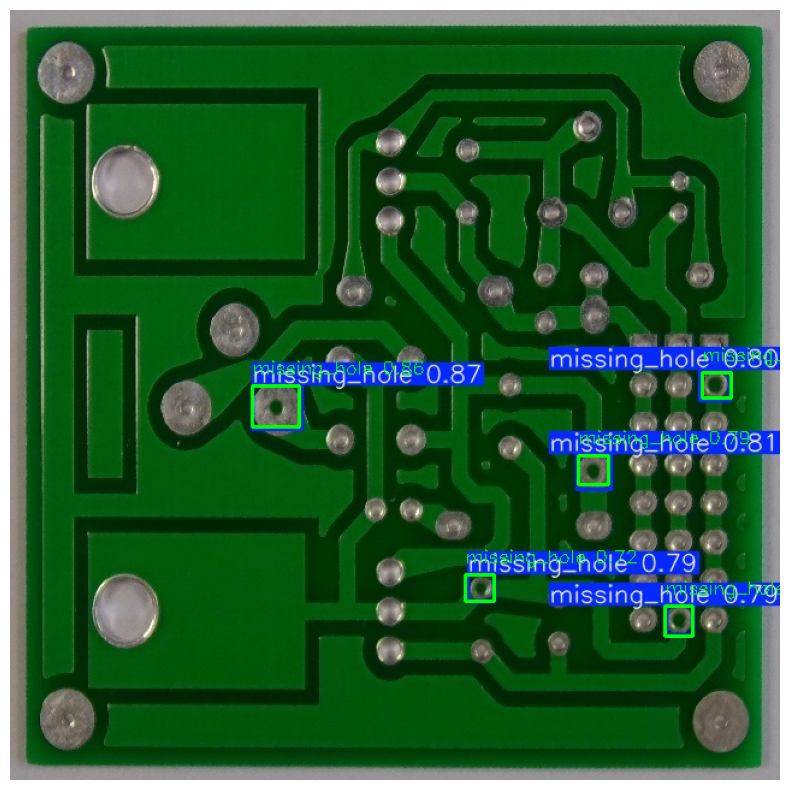

In [100]:
from ultralytics.utils.ops import non_max_suppression
import torch
import cv2
from ultralytics.utils.ops import non_max_suppression

# Load TorchScript model
ts_model = torch.jit.load("/content/images/results/weights/best.torchscript").to("cuda").eval()

# Read and preprocess image
img = cv2.imread("/content/images/results/predict/10_missing_hole_04.jpg")
img_resized = cv2.resize(img, (640, 640))
img_tensor = torch.from_numpy(img_resized).permute(2, 0, 1).float().div(255.0).unsqueeze(0).to("cuda")

# Inference
with torch.no_grad():
    preds = ts_model(img_tensor)

# Apply NMS (Ultralytics version works directly)
results = non_max_suppression(preds)[0]  # 0: batch index
# Draw results on image
for *xyxy, conf, cls in results:
    label = f"{model.names[int(cls)]} {conf:.2f}"
    xyxy = [int(x.item()) for x in xyxy]
    cv2.rectangle(img_resized, (xyxy[0], xyxy[1]), (xyxy[2], xyxy[3]), (0, 255, 0), 2)
    cv2.putText(img_resized, label, (xyxy[0], xyxy[1] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

# Show image
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


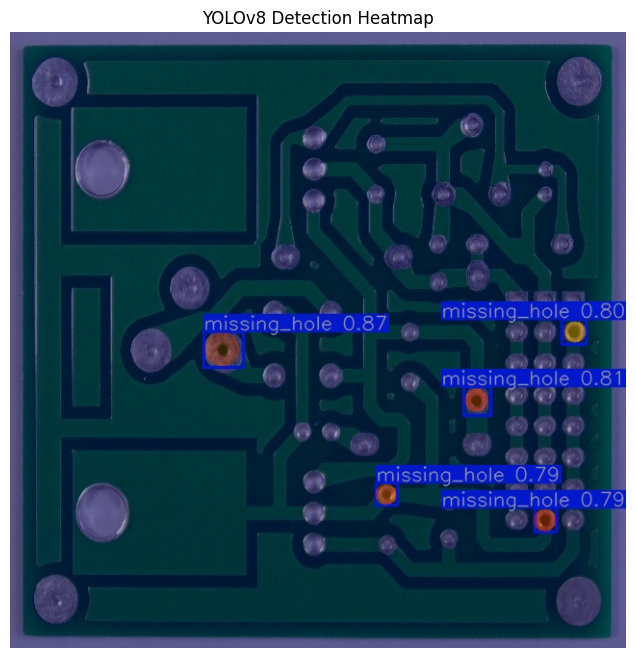

In [97]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics.utils.ops import non_max_suppression

# Load TorchScript model
ts_model = torch.jit.load("/content/images/results/weights/best.torchscript").to("cuda").eval()

# Load and preprocess image
image_path = "/content/images/results/predict/10_missing_hole_04.jpg"
img = cv2.imread(image_path)
img_resized = cv2.resize(img, (640, 640))
img_tensor = torch.from_numpy(img_resized).permute(2, 0, 1).float().div(255.0).unsqueeze(0).to("cuda")

# Inference
with torch.no_grad():
    preds = ts_model(img_tensor)

# Apply Non-Max Suppression
results = non_max_suppression(preds)[0]  # First image in batch

# Create heatmap base
heatmap = np.zeros((640, 640), dtype=np.float32)

# Draw heat over bounding boxes
for *xyxy, conf, cls in results:
    x1, y1, x2, y2 = map(int, xyxy)
    cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
    radius = max(10, int((x2 - x1 + y2 - y1) / 4))  # scale with box size

    # Draw a filled circle with intensity = confidence
    cv2.circle(heatmap, (cx, cy), radius, float(conf), thickness=-1)

# Normalize heatmap to 0-255
heatmap_normalized = np.uint8(255 * (heatmap / np.max(heatmap)))

# Apply colormap
colored_heatmap = cv2.applyColorMap(heatmap_normalized, cv2.COLORMAP_JET)

# Overlay heatmap onto original image
overlay = cv2.addWeighted(img_resized, 0.6, colored_heatmap, 0.4, 0)

# Show the image
plt.figure(figsize=(12, 8))
plt.title("YOLOv8 Detection Heatmap")
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


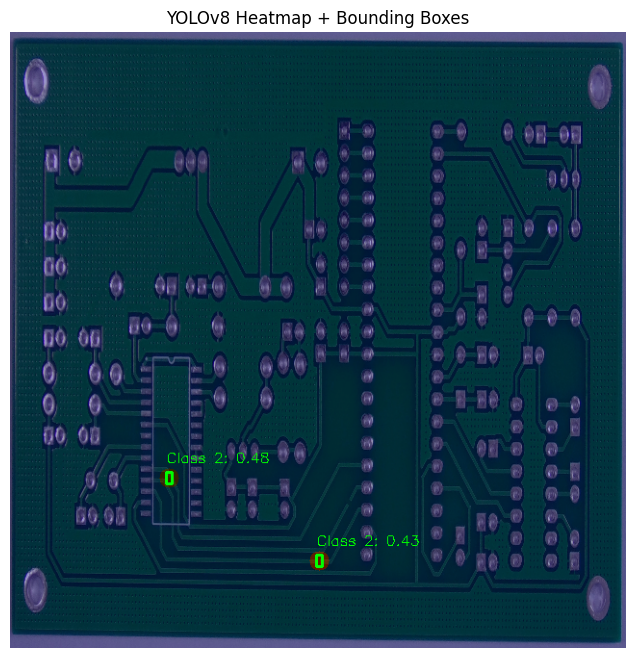

In [103]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics.utils.ops import non_max_suppression

# Load TorchScript model
ts_model = torch.jit.load("/content/images/results/weights/best.torchscript").to("cuda").eval()

# Load and preprocess image
image_path = "/content/images/PCB_DATASET/images/Open_circuit/01_open_circuit_02.jpg"
img = cv2.imread(image_path)
img_resized = cv2.resize(img, (640, 640))
img_tensor = torch.from_numpy(img_resized).permute(2, 0, 1).float().div(255.0).unsqueeze(0).to("cuda")

# Inference
with torch.no_grad():
    preds = ts_model(img_tensor)

# Apply Non-Max Suppression
results = non_max_suppression(preds)[0]  # First image in batch

# Create heatmap base
heatmap = np.zeros((640, 640), dtype=np.float32)

# Draw heat and collect boxes for later drawing
for *xyxy, conf, cls in results:
    x1, y1, x2, y2 = map(int, xyxy)
    cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
    radius = max(10, int((x2 - x1 + y2 - y1) / 4))  # scale with box size

    # Draw a filled circle with intensity = confidence
    cv2.circle(heatmap, (cx, cy), radius, float(conf), thickness=-1)

# Normalize heatmap to 0-255
heatmap_normalized = np.uint8(255 * (heatmap / np.max(heatmap)))

# Apply colormap
colored_heatmap = cv2.applyColorMap(heatmap_normalized, cv2.COLORMAP_JET)

# Overlay heatmap onto original image
overlay = cv2.addWeighted(img_resized, 0.6, colored_heatmap, 0.4, 0)

# Draw bounding boxes and labels on top of overlay
for *xyxy, conf, cls in results:
    x1, y1, x2, y2 = map(int, xyxy)
    label = f"Class {int(cls)}: {conf:.2f}"  # You can use model.names[int(cls)] if available
    cv2.rectangle(overlay, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(overlay, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX,
                0.5, (0, 255, 0), 1)

# Show the image
plt.figure(figsize=(12, 8))
plt.title("YOLOv8 Heatmap + Bounding Boxes")
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
